This Jupyter notebook uses the Sprague multipliers' methodology outlined in the paper "Reconstructing school-age populations by estimating population by single years of age for different polygons from raster data" for the Colombian Census of 2018. It uses raster data from WorldPop (https://www.worldpop.org/geodata/summary?id=16325), and the information on the Census was obtained from the National Bureau of Statistics of Colombia - DANE (http://microdatos.dane.gov.co/index.php/catalog/643/data_dictionary), from the 2018 National Census, for all 1118 municipalities. 

The information on the starting age and duration of each educational level, used for the reconstruction of the educational level populations for both census and projection data was obtained from data.uis.unesco.org, and is shown below:

The information on the starting age and duration of each educational level, used for the reconstruction of the educational level populations for both census and projection data was obtained from data.uis.unesco.org, and is shown below:

In [1]:
import pandas as pd
EducationSystem = {"Educational level": ["ECE", "Pre-primary", "Primary", "Lower secondary", "Upper secondary"], "Starting age": ["N/A","3","6","11","15"], "Duration":["6","3","5","4","2"]}
EducationSystem = pd.DataFrame(EducationSystem)  
print(EducationSystem)

  Educational level Starting age Duration
0               ECE          N/A        6
1       Pre-primary            3        3
2           Primary            6        5
3   Lower secondary           11        4
4   Upper secondary           15        2


In [ ]:
We start by importing all the necessary modules

In [1]:
import sys, os, csv, math, statsmodels
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.diagnostic as diag
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera
%matplotlib inline
%config InlineBackend.figure_format='retina'

The user is prompted to insert the appropriate working directory

In [2]:
os.chdir("C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\MP_01000298\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data\\Tables\\Colombia")  # REMOVE
if os.getcwd()!="C:\\Users\\g.vargas\\BOX\\IIEP_MyProjects\\MP_01000298\\WorkFiles_Experts\\298-Issue-Papers\\298-Issue-Paper-Sprague\\Replication files\\Data\\Tables\\Colombia":
    print("Please insert the WORKING DIRECTORY")                                                            # We create a loop so that the user establishes the working directory
    print("Remember to separate the backslash (for Windows) or forward slash (in Mac)") 
    while True:                                                                             
        NewPath=input()                                                                                     # The user inserts the working directory
        if os.path.exists(NewPath)==True:                                                                   # If the program exists, the working directory will be updated
            os.chdir(NewPath)                                                               
            print("Your new path is " + os.getcwd())                                        
            break                                                                                           # If the condition is met, the program keeps running
        else:                                                                                               # If the condition is not met, the program requests the user to
            print("Please check if the path is correctly written")                                          # insert a new path and the condition is checked again
        continue
else: 
    print("Your path is " + os.getcwd())

Your path is C:\Users\g.vargas\BOX\IIEP_MyProjects\MP_01000298\WorkFiles_Experts\298-Issue-Papers\298-Issue-Paper-Sprague\Replication files\Data\Tables\Colombia


We import the raw data from the 2018 Census, were we keep only 2018 data, and we rename the variables for ease of use

In [3]:
Colombia = pd.read_excel('anexo-proyecciones-poblacion-Municipal_2018-2026.xlsx', sheet_name='Municipal_2018_2026', skiprows=11)

In [4]:
Colombia = Colombia[Colombia['ÁREA GEOGRÁFICA']=='Total']
Colombia = Colombia[Colombia['AÑO']==2018]
del Colombia['AÑO']
del Colombia['ÁREA GEOGRÁFICA']
Colombia

,DP,DPNOM,DPMP,MPIO,Hombres_0,Hombres_1,Hombres_2,Hombres_3,Hombres_4,Hombres_5,...,Total_94,Total_95,Total_96,Total_97,Total_98,Total_99,Total_100 y más,Total Hombres,Total Mujeres,Total
2,5,Antioquia,5001,Medellín,14474,14600,14699,14782,14861,14942,...,936,783,627,566,495,482,1544,1140658,1286471,2427129
29,5,Antioquia,5002,Abejorral,132,130,129,132,136,141,...,6,7,7,4,5,9,15,10534,9833,20367
56,5,Antioquia,5004,Abriaquí,24,23,23,24,22,23,...,0,0,0,0,3,1,0,1452,1243,2695
83,5,Antioquia,5021,Alejandría,43,43,43,42,42,42,...,1,1,1,0,3,1,0,2320,2337,4657
110,5,Antioquia,5030,Amagá,204,202,203,203,204,204,...,13,6,5,4,5,9,9,14862,15365,30227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30161,97,Vaupés,97889,Yavaraté (CD),9,9,8,9,9,19,...,1,0,1,0,0,1,0,546,502,1048
30188,99,Vichada,99001,Puerto Carreño,231,232,230,230,229,226,...,2,2,2,1,2,3,4,11024,9912,20936
30215,99,Vichada,99524,La Primavera,111,112,110,112,108,111,...,2,2,1,0,0,6,2,5398,4724,10122
30242,99,Vichada,99624,Santa Rosalía,37,37,37,37,38,41,...,2,1,0,0,0,0,0,2130,1929,4059


In [5]:
Colombia = Colombia[['DP', 'DPNOM', 'DPMP', 'MPIO', 'Hombres_0', 'Hombres_1', 'Hombres_2', 'Hombres_3', 'Hombres_4', 'Hombres_5', 'Hombres_6', 'Hombres_7', 'Hombres_8', 'Hombres_9', 'Hombres_10', 'Hombres_11', 'Hombres_12', 'Hombres_13', 'Hombres_14', 'Hombres_15', 'Hombres_16', 'Hombres_17', 'Hombres_18', 'Hombres_19', 'Hombres_20', 'Hombres_21', 'Hombres_22', 'Hombres_23', 'Hombres_24', 'Hombres_25', 'Hombres_26', 'Hombres_27', 'Hombres_28', 'Hombres_29', 'Hombres_30', 'Hombres_31', 'Hombres_32', 'Hombres_33', 'Hombres_34', 'Hombres_35', 'Hombres_36', 'Hombres_37', 'Hombres_38', 'Hombres_39', 'Mujeres_0', 'Mujeres_1', 'Mujeres_2', 'Mujeres_3', 'Mujeres_4', 'Mujeres_5', 'Mujeres_6', 'Mujeres_7', 'Mujeres_8', 'Mujeres_9', 'Mujeres_10', 'Mujeres_11', 'Mujeres_12', 'Mujeres_13', 'Mujeres_14', 'Mujeres_15', 'Mujeres_16', 'Mujeres_17', 'Mujeres_18', 'Mujeres_19', 'Mujeres_20', 'Mujeres_21', 'Mujeres_22', 'Mujeres_23', 'Mujeres_24', 'Mujeres_25', 'Mujeres_26', 'Mujeres_27', 'Mujeres_28', 'Mujeres_29', 'Mujeres_30', 'Mujeres_31', 'Mujeres_32', 'Mujeres_33', 'Mujeres_34', 'Mujeres_35', 'Mujeres_36', 'Mujeres_37', 'Mujeres_38', 'Mujeres_39']]

In [6]:
Colombia.to_csv('Population_Colombia_clean.csv', index=False, header=["DpCode", "DpName", "admin2Pcod", "MunName", "Male_0", "Male_1", "Male_2", "Male_3", "Male_4", "Male_5", "Male_6", "Male_7", "Male_8", "Male_9", "Male_10", "Male_11", "Male_12", "Male_13", "Male_14", "Male_15", "Male_16", "Male_17", "Male_18", "Male_19", "Male_20", "Male_21", "Male_22", "Male_23", "Male_24", "Male_25", "Male_26", "Male_27", "Male_28", "Male_29", "Male_30", "Male_31", "Male_32", "Male_33", "Male_34", "Male_35", "Male_36", "Male_37", "Male_38", "Male_39", "Female_0", "Female_1", "Female_2", "Female_3", "Female_4", "Female_5", "Female_6", "Female_7", "Female_8", "Female_9", "Female_10", "Female_11", "Female_12", "Female_13", "Female_14", "Female_15", "Female_16", "Female_17", "Female_18", "Female_19", "Female_20", "Female_21", "Female_22", "Female_23", "Female_24", "Female_25", "Female_26", "Female_27", "Female_28", "Female_29", "Female_30", "Female_31", "Female_32", "Female_33", "Female_34", "Female_35", "Female_36", "Female_37", "Female_38", "Female_39"])

We now import the information that was obtained from applying the QGIS Sprague multipliers model, which can be found directly saved on the "Sprague multipliers - Colombia.gpkg" GeoPackage, as a Python script on "Sprague-multipliers-QGIS-model.py", or as a QGIS model on "Sprague-multipliers-QGIS-model.model3". We then proceed to apply the Sprague multipliers to obtain single years of age by sex and administrative boundary.

In [7]:
data = pd.read_csv("Administrative boundaries - Colombia.csv")
PopulationEstimates = pd.DataFrame(data, columns = ['admin2Pcod', 'F_0_to_1sum', 'F_1_to_4sum', 'F_5_to_9sum', 'F_10_to_14sum', 'F_15_to_19sum', 'F_20_to_24sum', 'F_25_to_29sum', 'F_30_to_34sum', 'F_35_to_39sum', 'M_0_to_1sum', 'M_1_to_4sum', 'M_5_to_9sum', 'M_10_to_14sum', 'M_15_to_19sum', 'M_20_to_24sum', 'M_25_to_29sum', 'M_30_to_34sum', 'M_35_to_39sum', 'Area'])

In [8]:
## We first create the variable for the groups 0 to 4 years

PopulationEstimates['M_0_to_4sum'] = PopulationEstimates['M_0_to_1sum'] + PopulationEstimates['M_1_to_4sum']
PopulationEstimates['F_0_to_4sum'] = PopulationEstimates['F_0_to_1sum'] + PopulationEstimates['F_1_to_4sum']

In [9]:
## We proceed to create the groups population by single years of age using the Sprague multipliers

# Male

PopulationEstimates['Y_M_0'] = 0.3616*PopulationEstimates['M_0_to_4sum'] - 0.2768*PopulationEstimates['M_5_to_9sum'] + 0.1488*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_1'] = 0.2640*PopulationEstimates['M_0_to_4sum'] - 0.0960*PopulationEstimates['M_5_to_9sum'] + 0.0400*PopulationEstimates['M_10_to_14sum'] - 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_2'] = 0.1840*PopulationEstimates['M_0_to_4sum'] + 0.0400*PopulationEstimates['M_5_to_9sum'] - 0.0320*PopulationEstimates['M_10_to_14sum'] + 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_3'] = 0.1200*PopulationEstimates['M_0_to_4sum'] + 0.1360*PopulationEstimates['M_5_to_9sum'] - 0.0720*PopulationEstimates['M_10_to_14sum'] + 0.0160*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_4'] = PopulationEstimates['M_0_to_4sum'] - PopulationEstimates['Y_M_0'] - PopulationEstimates['Y_M_1'] - PopulationEstimates['Y_M_2'] - PopulationEstimates['Y_M_3']
PopulationEstimates['Y_M_5'] = 0.0336*PopulationEstimates['M_0_to_4sum'] + 0.2272*PopulationEstimates['M_5_to_9sum'] - 0.0752*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_6'] = 0.0080*PopulationEstimates['M_0_to_4sum'] + 0.2320*PopulationEstimates['M_5_to_9sum'] - 0.0480*PopulationEstimates['M_10_to_14sum'] + 0.0080*PopulationEstimates['M_15_to_19sum'] 
PopulationEstimates['Y_M_7'] = -0.0080*PopulationEstimates['M_0_to_4sum'] + 0.2160*PopulationEstimates['M_5_to_9sum'] - 0.0080*PopulationEstimates['M_10_to_14sum'] + 0.0000*PopulationEstimates['M_15_to_19sum']
PopulationEstimates['Y_M_8'] = -0.0160*PopulationEstimates['M_0_to_4sum'] + 0.1840*PopulationEstimates['M_5_to_9sum'] + 0.0400*PopulationEstimates['M_10_to_14sum'] - 0.0080*PopulationEstimates['M_15_to_19sum']
PopulationEstimates['Y_M_9'] = PopulationEstimates['M_5_to_9sum'] - PopulationEstimates['Y_M_5'] - PopulationEstimates['Y_M_6'] - PopulationEstimates['Y_M_7'] - PopulationEstimates['Y_M_8']
PopulationEstimates['Y_M_10'] = -0.0128*PopulationEstimates['M_0_to_4sum'] + 0.0848*PopulationEstimates['M_5_to_9sum'] + 0.1504*PopulationEstimates['M_10_to_14sum'] - 0.0240*PopulationEstimates['M_15_to_19sum'] + 0.0016*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_11'] = -0.0016*PopulationEstimates['M_0_to_4sum'] + 0.0144*PopulationEstimates['M_5_to_9sum'] + 0.2224*PopulationEstimates['M_10_to_14sum'] - 0.0416*PopulationEstimates['M_15_to_19sum'] + 0.0064*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_12'] = 0.0064*PopulationEstimates['M_0_to_4sum'] - 0.0336*PopulationEstimates['M_5_to_9sum'] + 0.2544*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] + 0.0064*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_13'] = 0.0064*PopulationEstimates['M_0_to_4sum'] - 0.0416*PopulationEstimates['M_5_to_9sum'] + 0.2224*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] - 0.0016*PopulationEstimates['M_20_to_24sum']
PopulationEstimates['Y_M_14'] = PopulationEstimates['M_10_to_14sum'] - PopulationEstimates['Y_M_10'] - PopulationEstimates['Y_M_11'] - PopulationEstimates['Y_M_12'] - PopulationEstimates['Y_M_13']
PopulationEstimates['Y_M_15'] = -0.0128*PopulationEstimates['M_5_to_9sum'] + 0.0848*PopulationEstimates['M_10_to_14sum'] + 0.1504*PopulationEstimates['M_15_to_19sum'] - 0.0240*PopulationEstimates['M_20_to_24sum'] + 0.0016*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_16'] = -0.0016*PopulationEstimates['M_5_to_9sum'] + 0.0144*PopulationEstimates['M_10_to_14sum'] + 0.2224*PopulationEstimates['M_15_to_19sum'] - 0.0416*PopulationEstimates['M_20_to_24sum'] + 0.0064*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_17'] = 0.0064*PopulationEstimates['M_5_to_9sum'] - 0.0336*PopulationEstimates['M_10_to_14sum'] + 0.2544*PopulationEstimates['M_15_to_19sum'] - 0.0336*PopulationEstimates['M_20_to_24sum'] + 0.0064*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_18'] = 0.0064*PopulationEstimates['M_5_to_9sum'] - 0.0416*PopulationEstimates['M_10_to_14sum'] + 0.2224*PopulationEstimates['M_15_to_19sum'] + 0.0144*PopulationEstimates['M_20_to_24sum'] - 0.0016*PopulationEstimates['M_25_to_29sum']
PopulationEstimates['Y_M_19'] = PopulationEstimates['M_15_to_19sum'] - PopulationEstimates['Y_M_15'] - PopulationEstimates['Y_M_16'] - PopulationEstimates['Y_M_17'] - PopulationEstimates['Y_M_18']
PopulationEstimates['Y_M_20'] = -0.0128*PopulationEstimates['M_10_to_14sum'] + 0.0848*PopulationEstimates['M_15_to_19sum'] + 0.1504*PopulationEstimates['M_20_to_24sum'] - 0.0240*PopulationEstimates['M_25_to_29sum'] + 0.0016*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_21'] = -0.0016*PopulationEstimates['M_10_to_14sum'] + 0.0144*PopulationEstimates['M_15_to_19sum'] + 0.2224*PopulationEstimates['M_20_to_24sum'] - 0.0416*PopulationEstimates['M_25_to_29sum'] + 0.0064*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_22'] = 0.0064*PopulationEstimates['M_10_to_14sum'] - 0.0336*PopulationEstimates['M_15_to_19sum'] + 0.2544*PopulationEstimates['M_20_to_24sum'] - 0.0336*PopulationEstimates['M_25_to_29sum'] + 0.0064*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_23'] = 0.0064*PopulationEstimates['M_10_to_14sum'] - 0.0416*PopulationEstimates['M_15_to_19sum'] + 0.2224*PopulationEstimates['M_20_to_24sum'] + 0.0144*PopulationEstimates['M_25_to_29sum'] - 0.0016*PopulationEstimates['M_30_to_34sum']
PopulationEstimates['Y_M_24'] = PopulationEstimates['M_20_to_24sum'] - PopulationEstimates['Y_M_20'] - PopulationEstimates['Y_M_21'] - PopulationEstimates['Y_M_22'] - PopulationEstimates['Y_M_23']
PopulationEstimates['Y_M_25'] = -0.0128*PopulationEstimates['M_15_to_19sum'] + 0.0848*PopulationEstimates['M_20_to_24sum'] + 0.1504*PopulationEstimates['M_25_to_29sum'] - 0.0240*PopulationEstimates['M_30_to_34sum'] + 0.0016*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_26'] = -0.0016*PopulationEstimates['M_15_to_19sum'] + 0.0144*PopulationEstimates['M_20_to_24sum'] + 0.2224*PopulationEstimates['M_25_to_29sum'] - 0.0416*PopulationEstimates['M_30_to_34sum'] + 0.0064*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_27'] = 0.0064*PopulationEstimates['M_15_to_19sum'] - 0.0336*PopulationEstimates['M_20_to_24sum'] + 0.2544*PopulationEstimates['M_25_to_29sum'] - 0.0336*PopulationEstimates['M_30_to_34sum'] + 0.0064*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_28'] = 0.0064*PopulationEstimates['M_15_to_19sum'] - 0.0416*PopulationEstimates['M_20_to_24sum'] + 0.2224*PopulationEstimates['M_25_to_29sum'] + 0.0144*PopulationEstimates['M_30_to_34sum'] - 0.0016*PopulationEstimates['M_35_to_39sum']
PopulationEstimates['Y_M_29'] = PopulationEstimates['M_25_to_29sum'] - PopulationEstimates['Y_M_25'] - PopulationEstimates['Y_M_26'] - PopulationEstimates['Y_M_27'] - PopulationEstimates['Y_M_28']


In [10]:
# Female

PopulationEstimates['Y_F_0'] = 0.3616*PopulationEstimates['F_0_to_4sum'] - 0.2768*PopulationEstimates['F_5_to_9sum'] + 0.1488*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_1'] = 0.2640*PopulationEstimates['F_0_to_4sum'] - 0.0960*PopulationEstimates['F_5_to_9sum'] + 0.0400*PopulationEstimates['F_10_to_14sum'] - 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_2'] = 0.1840*PopulationEstimates['F_0_to_4sum'] + 0.0400*PopulationEstimates['F_5_to_9sum'] - 0.0320*PopulationEstimates['F_10_to_14sum'] + 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_3'] = 0.1200*PopulationEstimates['F_0_to_4sum'] + 0.1360*PopulationEstimates['F_5_to_9sum'] - 0.0720*PopulationEstimates['F_10_to_14sum'] + 0.0160*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_4'] = PopulationEstimates['F_0_to_4sum'] - PopulationEstimates['Y_F_0'] - PopulationEstimates['Y_F_1'] - PopulationEstimates['Y_F_2'] - PopulationEstimates['Y_F_3']
PopulationEstimates['Y_F_5'] = 0.0336*PopulationEstimates['F_0_to_4sum'] + 0.2272*PopulationEstimates['F_5_to_9sum'] - 0.0752*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_6'] = 0.0080*PopulationEstimates['F_0_to_4sum'] + 0.2320*PopulationEstimates['F_5_to_9sum'] - 0.0480*PopulationEstimates['F_10_to_14sum'] + 0.0080*PopulationEstimates['F_15_to_19sum'] 
PopulationEstimates['Y_F_7'] = -0.0080*PopulationEstimates['F_0_to_4sum'] + 0.2160*PopulationEstimates['F_5_to_9sum'] - 0.0080*PopulationEstimates['F_10_to_14sum'] + 0.0000*PopulationEstimates['F_15_to_19sum']
PopulationEstimates['Y_F_8'] = -0.0160*PopulationEstimates['F_0_to_4sum'] + 0.1840*PopulationEstimates['F_5_to_9sum'] + 0.0400*PopulationEstimates['F_10_to_14sum'] - 0.0080*PopulationEstimates['F_15_to_19sum']
PopulationEstimates['Y_F_9'] = PopulationEstimates['F_5_to_9sum'] - PopulationEstimates['Y_F_5'] - PopulationEstimates['Y_F_6'] - PopulationEstimates['Y_F_7'] - PopulationEstimates['Y_F_8']
PopulationEstimates['Y_F_10'] = -0.0128*PopulationEstimates['F_0_to_4sum'] + 0.0848*PopulationEstimates['F_5_to_9sum'] + 0.1504*PopulationEstimates['F_10_to_14sum'] - 0.0240*PopulationEstimates['F_15_to_19sum'] + 0.0016*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_11'] = -0.0016*PopulationEstimates['F_0_to_4sum'] + 0.0144*PopulationEstimates['F_5_to_9sum'] + 0.2224*PopulationEstimates['F_10_to_14sum'] - 0.0416*PopulationEstimates['F_15_to_19sum'] + 0.0064*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_12'] = 0.0064*PopulationEstimates['F_0_to_4sum'] - 0.0336*PopulationEstimates['F_5_to_9sum'] + 0.2544*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] + 0.0064*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_13'] = 0.0064*PopulationEstimates['F_0_to_4sum'] - 0.0416*PopulationEstimates['F_5_to_9sum'] + 0.2224*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] - 0.0016*PopulationEstimates['F_20_to_24sum']
PopulationEstimates['Y_F_14'] = PopulationEstimates['F_10_to_14sum'] - PopulationEstimates['Y_F_10'] - PopulationEstimates['Y_F_11'] - PopulationEstimates['Y_F_12'] - PopulationEstimates['Y_F_13']
PopulationEstimates['Y_F_15'] = -0.0128*PopulationEstimates['F_5_to_9sum'] + 0.0848*PopulationEstimates['F_10_to_14sum'] + 0.1504*PopulationEstimates['F_15_to_19sum'] - 0.0240*PopulationEstimates['F_20_to_24sum'] + 0.0016*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_16'] = -0.0016*PopulationEstimates['F_5_to_9sum'] + 0.0144*PopulationEstimates['F_10_to_14sum'] + 0.2224*PopulationEstimates['F_15_to_19sum'] - 0.0416*PopulationEstimates['F_20_to_24sum'] + 0.0064*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_17'] = 0.0064*PopulationEstimates['F_5_to_9sum'] - 0.0336*PopulationEstimates['F_10_to_14sum'] + 0.2544*PopulationEstimates['F_15_to_19sum'] - 0.0336*PopulationEstimates['F_20_to_24sum'] + 0.0064*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_18'] = 0.0064*PopulationEstimates['F_5_to_9sum'] - 0.0416*PopulationEstimates['F_10_to_14sum'] + 0.2224*PopulationEstimates['F_15_to_19sum'] + 0.0144*PopulationEstimates['F_20_to_24sum'] - 0.0016*PopulationEstimates['F_25_to_29sum']
PopulationEstimates['Y_F_19'] = PopulationEstimates['F_15_to_19sum'] - PopulationEstimates['Y_F_15'] - PopulationEstimates['Y_F_16'] - PopulationEstimates['Y_F_17'] - PopulationEstimates['Y_F_18']
PopulationEstimates['Y_F_20'] = -0.0128*PopulationEstimates['F_10_to_14sum'] + 0.0848*PopulationEstimates['F_15_to_19sum'] + 0.1504*PopulationEstimates['F_20_to_24sum'] - 0.0240*PopulationEstimates['F_25_to_29sum'] + 0.0016*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_21'] = -0.0016*PopulationEstimates['F_10_to_14sum'] + 0.0144*PopulationEstimates['F_15_to_19sum'] + 0.2224*PopulationEstimates['F_20_to_24sum'] - 0.0416*PopulationEstimates['F_25_to_29sum'] + 0.0064*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_22'] = 0.0064*PopulationEstimates['F_10_to_14sum'] - 0.0336*PopulationEstimates['F_15_to_19sum'] + 0.2544*PopulationEstimates['F_20_to_24sum'] - 0.0336*PopulationEstimates['F_25_to_29sum'] + 0.0064*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_23'] = 0.0064*PopulationEstimates['F_10_to_14sum'] - 0.0416*PopulationEstimates['F_15_to_19sum'] + 0.2224*PopulationEstimates['F_20_to_24sum'] + 0.0144*PopulationEstimates['F_25_to_29sum'] - 0.0016*PopulationEstimates['F_30_to_34sum']
PopulationEstimates['Y_F_24'] = PopulationEstimates['F_20_to_24sum'] - PopulationEstimates['Y_F_20'] - PopulationEstimates['Y_F_21'] - PopulationEstimates['Y_F_22'] - PopulationEstimates['Y_F_23']
PopulationEstimates['Y_F_25'] = -0.0128*PopulationEstimates['F_15_to_19sum'] + 0.0848*PopulationEstimates['F_20_to_24sum'] + 0.1504*PopulationEstimates['F_25_to_29sum'] - 0.0240*PopulationEstimates['F_30_to_34sum'] + 0.0016*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_26'] = -0.0016*PopulationEstimates['F_15_to_19sum'] + 0.0144*PopulationEstimates['F_20_to_24sum'] + 0.2224*PopulationEstimates['F_25_to_29sum'] - 0.0416*PopulationEstimates['F_30_to_34sum'] + 0.0064*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_27'] = 0.0064*PopulationEstimates['F_15_to_19sum'] - 0.0336*PopulationEstimates['F_20_to_24sum'] + 0.2544*PopulationEstimates['F_25_to_29sum'] - 0.0336*PopulationEstimates['F_30_to_34sum'] + 0.0064*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_28'] = 0.0064*PopulationEstimates['F_15_to_19sum'] - 0.0416*PopulationEstimates['F_20_to_24sum'] + 0.2224*PopulationEstimates['F_25_to_29sum'] + 0.0144*PopulationEstimates['F_30_to_34sum'] - 0.0016*PopulationEstimates['F_35_to_39sum']
PopulationEstimates['Y_F_29'] = PopulationEstimates['F_25_to_29sum'] - PopulationEstimates['Y_F_25'] - PopulationEstimates['Y_F_26'] - PopulationEstimates['Y_F_27'] - PopulationEstimates['Y_F_28']


In [11]:
# Total

PopulationEstimates['Y_T_0'] = PopulationEstimates['Y_M_0'] + PopulationEstimates['Y_F_0']
PopulationEstimates['Y_T_1'] = PopulationEstimates['Y_M_1'] + PopulationEstimates['Y_F_1']
PopulationEstimates['Y_T_2'] = PopulationEstimates['Y_M_2'] + PopulationEstimates['Y_F_2']
PopulationEstimates['Y_T_3'] = PopulationEstimates['Y_M_3'] + PopulationEstimates['Y_F_3']
PopulationEstimates['Y_T_4'] = PopulationEstimates['Y_M_4'] + PopulationEstimates['Y_F_4']
PopulationEstimates['Y_T_5'] = PopulationEstimates['Y_M_5'] + PopulationEstimates['Y_F_5']
PopulationEstimates['Y_T_6'] = PopulationEstimates['Y_M_6'] + PopulationEstimates['Y_F_6']
PopulationEstimates['Y_T_7'] = PopulationEstimates['Y_M_7'] + PopulationEstimates['Y_F_7']
PopulationEstimates['Y_T_8'] = PopulationEstimates['Y_M_8'] + PopulationEstimates['Y_F_8']
PopulationEstimates['Y_T_9'] = PopulationEstimates['Y_M_9'] + PopulationEstimates['Y_F_9']
PopulationEstimates['Y_T_10'] = PopulationEstimates['Y_M_10'] + PopulationEstimates['Y_F_10']
PopulationEstimates['Y_T_11'] = PopulationEstimates['Y_M_11'] + PopulationEstimates['Y_F_11']
PopulationEstimates['Y_T_12'] = PopulationEstimates['Y_M_12'] + PopulationEstimates['Y_F_12']
PopulationEstimates['Y_T_13'] = PopulationEstimates['Y_M_13'] + PopulationEstimates['Y_F_13']
PopulationEstimates['Y_T_14'] = PopulationEstimates['Y_M_14'] + PopulationEstimates['Y_F_14']
PopulationEstimates['Y_T_15'] = PopulationEstimates['Y_M_15'] + PopulationEstimates['Y_F_15']
PopulationEstimates['Y_T_16'] = PopulationEstimates['Y_M_16'] + PopulationEstimates['Y_F_16']
PopulationEstimates['Y_T_17'] = PopulationEstimates['Y_M_17'] + PopulationEstimates['Y_F_17']
PopulationEstimates['Y_T_18'] = PopulationEstimates['Y_M_18'] + PopulationEstimates['Y_F_18']
PopulationEstimates['Y_T_19'] = PopulationEstimates['Y_M_19'] + PopulationEstimates['Y_F_19']
PopulationEstimates['Y_T_20'] = PopulationEstimates['Y_M_20'] + PopulationEstimates['Y_F_20']
PopulationEstimates['Y_T_21'] = PopulationEstimates['Y_M_21'] + PopulationEstimates['Y_F_21']
PopulationEstimates['Y_T_22'] = PopulationEstimates['Y_M_22'] + PopulationEstimates['Y_F_22']
PopulationEstimates['Y_T_23'] = PopulationEstimates['Y_M_23'] + PopulationEstimates['Y_F_23']
PopulationEstimates['Y_T_24'] = PopulationEstimates['Y_M_24'] + PopulationEstimates['Y_F_24']
PopulationEstimates['Y_T_25'] = PopulationEstimates['Y_M_25'] + PopulationEstimates['Y_F_25']
PopulationEstimates['Y_T_26'] = PopulationEstimates['Y_M_26'] + PopulationEstimates['Y_F_26']
PopulationEstimates['Y_T_27'] = PopulationEstimates['Y_M_27'] + PopulationEstimates['Y_F_27']
PopulationEstimates['Y_T_28'] = PopulationEstimates['Y_M_28'] + PopulationEstimates['Y_F_28']
PopulationEstimates['Y_T_29'] = PopulationEstimates['Y_M_29'] + PopulationEstimates['Y_F_29']

In [12]:
PopulationEstimates['admin2Pcod'] = PopulationEstimates['admin2Pcod'].str[-5:]
PopulationEstimates['admin2Pcod'] = PopulationEstimates['admin2Pcod'].apply(int)
PopulationEstimates

,admin2Pcod,F_0_to_1sum,F_1_to_4sum,F_5_to_9sum,F_10_to_14sum,F_15_to_19sum,F_20_to_24sum,F_25_to_29sum,F_30_to_34sum,F_35_to_39sum,...,Y_T_20,Y_T_21,Y_T_22,Y_T_23,Y_T_24,Y_T_25,Y_T_26,Y_T_27,Y_T_28,Y_T_29
0,44847,3347.920330,13554.574507,12920.106562,11941.763756,11546.076291,11551.038732,11300.476362,10132.282973,8964.042689,...,4539.445080,4526.253867,4511.911163,4494.392072,4472.117868,4447.622484,4422.904450,4376.892541,4300.139642,4202.423440
1,44560,2586.673944,10472.550488,9982.347160,9226.458850,8920.742355,8924.576446,8730.986670,7828.415785,6925.808671,...,3507.271126,3497.079316,3485.997840,3472.462221,3455.252701,3436.327050,3417.229376,3381.679603,3322.378693,3246.881092
2,44430,2914.509383,11799.843089,11247.511317,10395.821608,10051.358564,10055.678585,9837.553209,8820.590360,7803.586690,...,3951.783189,3940.299668,3927.813723,3912.562598,3893.171941,3871.847649,3850.329532,3810.274176,3743.457460,3658.391281
3,44001,4450.494673,18018.517678,17175.099703,15874.558156,15348.558499,15355.155225,15022.074871,13469.159045,11916.180889,...,6034.425601,6016.890111,5997.823908,5974.535236,5944.925444,5912.362968,5879.504517,5818.339454,5716.309438,5586.412249
4,47001,5772.449844,23370.657996,27092.771466,27056.805110,26819.649363,25291.153621,25718.618224,24994.391926,22477.567306,...,10388.526877,10130.137456,9968.545797,9964.780393,10060.178114,10132.590050,10203.497242,10244.405554,10227.870112,10168.092024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,19785,77.074772,312.049167,402.680850,416.858918,420.752077,421.387226,420.851001,378.249121,336.354697,...,169.850436,169.344534,169.121717,169.390013,169.815714,169.984805,170.133352,169.029017,166.065315,161.859437
1113,50270,29.533956,119.572802,151.414503,164.617004,161.320756,160.623003,164.643662,161.268345,150.714120,...,63.919280,63.641800,63.587753,63.861634,64.323963,64.734922,65.147466,65.338250,65.173281,64.748820
1114,94663,79.939353,323.646848,434.016035,426.787059,361.090708,333.326623,370.203978,359.940996,312.033568,...,138.310671,132.352646,129.763755,132.337097,138.110868,143.422614,149.115759,152.720002,152.670924,150.165547
1115,88001,558.944562,2262.973678,2867.360331,3071.917020,2702.732564,2796.431535,3076.437992,3158.812566,3582.468147,...,1122.995695,1127.107956,1134.698106,1146.005543,1159.605836,1175.327582,1194.995972,1206.928254,1205.862884,1197.794931


Once we eliminate the old variables, we have a clean estimation for municipality in the 2018 Census data.

In [13]:

# We eliminate the old variables

OldVariables = ['F_0_to_1sum', 'F_0_to_4sum', 'F_1_to_4sum', 'F_5_to_9sum', 'F_10_to_14sum', 'F_15_to_19sum', 'F_20_to_24sum', 'F_25_to_29sum', 'F_30_to_34sum', 'F_35_to_39sum', 'M_0_to_1sum', 'M_0_to_4sum', 'M_1_to_4sum', 'M_5_to_9sum', 'M_10_to_14sum', 'M_15_to_19sum', 'M_20_to_24sum', 'M_25_to_29sum', 'M_30_to_34sum', 'M_35_to_39sum']

for Variable in OldVariables:
    del PopulationEstimates[Variable]

# Once the calculation is ready, we export the file, again as a CSV file, to be imported into QGIS and merged using the 'admin3Name' variable as key

PopulationEstimates.to_csv("Administrative boundaries - Colombia Clean.csv", encoding='utf-8', index=False, header=True)
PopulationEstimates

,admin2Pcod,Area,Y_M_0,Y_M_1,Y_M_2,Y_M_3,Y_M_4,Y_M_5,Y_M_6,Y_M_7,...,Y_T_20,Y_T_21,Y_T_22,Y_T_23,Y_T_24,Y_T_25,Y_T_26,Y_T_27,Y_T_28,Y_T_29
0,44847,791995.938369,3974.420225,3687.905415,3441.814262,3232.768133,3057.388394,2912.296413,2794.113556,2699.461190,...,4539.445080,4526.253867,4511.911163,4494.392072,4472.117868,4447.622484,4422.904450,4376.892541,4300.139642,4202.423440
1,44560,162067.719821,3070.720992,2849.353599,2659.218378,2497.704925,2362.202835,2250.101707,2158.791136,2085.660719,...,3507.271126,3497.079316,3485.997840,3472.462221,3455.252701,3436.327050,3417.229376,3381.679603,3322.378693,3246.881092
2,44430,221160.793504,3459.904627,3210.481098,2996.248110,2814.264417,2661.588773,2535.279931,2432.396644,2349.997668,...,3951.783189,3940.299668,3927.813723,3912.562598,3893.171941,3871.847649,3850.329532,3810.274176,3743.457460,3658.391281
3,44001,318620.170351,5283.320480,4902.447427,4575.310800,4297.419275,4064.281531,3871.406245,3714.302096,3588.477760,...,6034.425601,6016.890111,5997.823908,5974.535236,5944.925444,5912.362968,5879.504517,5818.339454,5716.309438,5586.412249
4,47001,235332.727516,6525.222921,6308.821325,6133.268787,5994.479524,5888.367755,5810.847697,5757.833569,5725.239587,...,10388.526877,10130.137456,9968.545797,9964.780393,10060.178114,10132.590050,10203.497242,10244.405554,10227.870112,10168.092024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,19785,13443.880889,79.652215,79.921312,80.379463,80.992259,81.725292,82.544151,83.414429,84.301715,...,169.850436,169.344534,169.121717,169.390013,169.815714,169.984805,170.133352,169.029017,166.065315,161.859437
1113,50270,13055.016034,31.921067,31.553936,31.384728,31.384340,31.523670,31.773615,32.105072,32.488940,...,63.919280,63.641800,63.587753,63.861634,64.323963,64.734922,65.147466,65.338250,65.173281,64.748820
1114,94663,490806.209319,69.649749,77.001633,82.806744,87.207285,90.345457,92.363460,93.403498,93.607770,...,138.310671,132.352646,129.763755,132.337097,138.110868,143.422614,149.115759,152.720002,152.670924,150.165547
1115,88001,4885.704121,646.317703,614.413310,591.321410,576.006828,567.434391,564.568924,566.375253,571.818204,...,1122.995695,1127.107956,1134.698106,1146.005543,1159.605836,1175.327582,1194.995972,1206.928254,1205.862884,1197.794931


## Comparing the estimated population with the actual population

### Creating the different age groups for Colombia

This information was obtained from the UNESCO Institute of Statistics (data.uis.unesco.org).

#### Census data


In [14]:
CensusData = pd.read_csv("Population_Colombia_clean.csv")

CensusData['admin2Pcod'] = CensusData['admin2Pcod'].apply(int)

# ECE (Starting age: 3 years old - Duration: 3 years)
#CensusData['CD_ECE_Female'] = CensusData['Female_3'] + CensusData['Female_4'] + CensusData['Female_5'] 
#CensusData['CD_ECE_Male'] = CensusData['Male_3'] + CensusData['Male_4'] + CensusData['Male_5']
#CensusData['CD_ECE'] = CensusData['CD_ECE_Female'] + CensusData['CD_ECE_Male']

# Pre-primary (Starting age: 3 years old - Duration: 3 years)
CensusData['CD_PrePrimary_Female'] = CensusData['Female_3'] + CensusData['Female_4'] + CensusData['Female_5'] 
CensusData['CD_PrePrimary_Male'] = CensusData['Male_3'] + CensusData['Male_4'] + CensusData['Male_5']
CensusData['CD_PrePrimary'] = CensusData['CD_PrePrimary_Female'] + CensusData['CD_PrePrimary_Male']

# Primary (Starting age: 6 years old - Duration: 5 years)
CensusData['CD_Primary_Female'] = CensusData['Female_6'] + CensusData['Female_7'] + CensusData['Female_8'] + CensusData['Female_9'] + CensusData['Female_10']
CensusData['CD_Primary_Male'] = CensusData['Male_6'] + CensusData['Male_7'] + CensusData['Male_8'] + CensusData['Male_9'] + CensusData['Male_10']
CensusData['CD_Primary'] = CensusData['CD_Primary_Female'] + CensusData['CD_Primary_Male']

# Lower secondary (Starting age: 11 years old - Duration: 4 years)
CensusData['CD_LowSec_Female'] = CensusData['Female_11'] + CensusData['Female_12'] + CensusData['Female_13'] + CensusData['Female_14'] 
CensusData['CD_LowSec_Male'] = CensusData['Male_11'] + CensusData['Male_12'] + CensusData['Male_13'] + CensusData['Male_14']
CensusData['CD_LowSec'] = CensusData['CD_LowSec_Female'] + CensusData['CD_LowSec_Male']

# Upper secondary (Starting age: 15 years old - Duration: 3 years)
CensusData['CD_UpSec_Female'] = CensusData['Female_15'] + CensusData['Female_16'] 
CensusData['CD_UpSec_Male'] = CensusData['Male_15'] + CensusData['Male_16'] 
CensusData['CD_UpSec'] = CensusData['CD_UpSec_Female'] + CensusData['CD_UpSec_Male']

#### Estimated data

In [15]:
# ECE (Starting age: 3 years old - Duration: 3 years)
#PopulationEstimates['PE_ECE_Female'] = PopulationEstimates['Y_F_3'] + PopulationEstimates['Y_F_4'] + PopulationEstimates['Y_F_5'] 
#PopulationEstimates['PE_ECE_Male'] = PopulationEstimates['Y_M_3'] + PopulationEstimates['Y_M_4'] + PopulationEstimates['Y_M_5']
#PopulationEstimates['PE_ECE'] = PopulationEstimates['PE_ECE_Female'] + PopulationEstimates['PE_ECE_Male']

# Pre-primary (Starting age: 3 years old - Duration: 1 years)
PopulationEstimates['PE_PrePrimary_Female'] = PopulationEstimates['Y_F_3'] + PopulationEstimates['Y_F_4'] + PopulationEstimates['Y_F_5'] 
PopulationEstimates['PE_PrePrimary_Male'] = PopulationEstimates['Y_M_3'] + PopulationEstimates['Y_M_4'] + PopulationEstimates['Y_M_5'] 
PopulationEstimates['PE_PrePrimary'] = PopulationEstimates['PE_PrePrimary_Female'] + PopulationEstimates['PE_PrePrimary_Male']

# Primary (Starting age: 6 years old - Duration: 5 years)
PopulationEstimates['PE_Primary_Female'] = PopulationEstimates['Y_F_6'] + PopulationEstimates['Y_F_7'] + PopulationEstimates['Y_F_8'] + PopulationEstimates['Y_F_9'] + PopulationEstimates['Y_F_10'] + PopulationEstimates['Y_F_11']
PopulationEstimates['PE_Primary_Male'] = PopulationEstimates['Y_M_6'] + PopulationEstimates['Y_M_7'] + PopulationEstimates['Y_M_8'] + PopulationEstimates['Y_M_9'] + PopulationEstimates['Y_M_10'] + PopulationEstimates['Y_M_11']
PopulationEstimates['PE_Primary'] = PopulationEstimates['PE_Primary_Female'] + PopulationEstimates['PE_Primary_Male']

# Lower secondary (Starting age: 11 years old - Duration: 4 years)
PopulationEstimates['PE_LowSec_Female'] = PopulationEstimates['Y_F_12'] + PopulationEstimates['Y_F_13'] + PopulationEstimates['Y_F_14'] 
PopulationEstimates['PE_LowSec_Male'] = PopulationEstimates['Y_M_12'] + PopulationEstimates['Y_M_13'] + PopulationEstimates['Y_M_14']
PopulationEstimates['PE_LowSec'] = PopulationEstimates['PE_LowSec_Female'] + PopulationEstimates['PE_LowSec_Male']

# Upper secondary (Starting age: 15 years old - Duration: 2 years)
PopulationEstimates['PE_UpSec_Female'] = PopulationEstimates['Y_F_15'] + PopulationEstimates['Y_F_16'] 
PopulationEstimates['PE_UpSec_Male'] = PopulationEstimates['Y_M_15'] + PopulationEstimates['Y_M_16'] 
PopulationEstimates['PE_UpSec'] = PopulationEstimates['PE_UpSec_Female'] + PopulationEstimates['PE_UpSec_Male']

### Combining the databases

We combine the two datasets using the unique identifying code, keeping only the identifiers, the Area of the polygon, and the relevant educational level population groups by sex.

In [16]:
MergedData = pd.merge(CensusData, PopulationEstimates, how='inner', on='admin2Pcod')
MergedData = MergedData[["DpCode", "DpName", "admin2Pcod", 'MunName', 'PE_PrePrimary_Female', 'PE_PrePrimary_Male', 'PE_PrePrimary', 'PE_Primary_Female', 'PE_Primary_Male', 'PE_Primary', 'PE_LowSec_Female', 'PE_LowSec_Male', 'PE_LowSec', 'PE_UpSec_Female', 'PE_UpSec_Male', 'PE_UpSec', 'CD_PrePrimary_Female', 'CD_PrePrimary_Male', 'CD_PrePrimary', 'CD_Primary_Female', 'CD_Primary_Male', 'CD_Primary', 'CD_LowSec_Female', 'CD_LowSec_Male', 'CD_LowSec', 'CD_UpSec_Female', 'CD_UpSec_Male', 'CD_UpSec', 'Area']]
MergedData

,DpCode,DpName,admin2Pcod,MunName,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,PE_Primary_Male,PE_Primary,...,CD_Primary_Female,CD_Primary_Male,CD_Primary,CD_LowSec_Female,CD_LowSec_Male,CD_LowSec,CD_UpSec_Female,CD_UpSec_Male,CD_UpSec,Area
0,5,Antioquia,5001,Medellín,60034.652190,62523.359457,122558.011647,128654.128193,134286.522860,262940.651053,...,74458,76732,151190,65054,66591,131645,35720,36446,72166,3.723861e+04
1,5,Antioquia,5002,Abejorral,539.229370,561.592860,1100.822231,1155.624687,1206.233050,2361.857737,...,731,780,1511,629,707,1336,320,369,689,5.072647e+04
2,5,Antioquia,5004,Abriaquí,72.337968,75.336703,147.674671,155.020107,161.806787,316.826894,...,98,113,211,78,94,172,39,52,91,2.887893e+04
3,5,Antioquia,5021,Alejandría,100.546837,104.714957,205.261794,215.471652,224.904861,440.376513,...,186,196,382,136,151,287,66,76,142,1.265684e+04
4,5,Antioquia,5030,Amagá,728.612361,758.816632,1487.428992,1561.414695,1629.772422,3191.187117,...,1013,1048,2061,870,896,1766,463,479,942,8.308035e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,97,Vaupés,97889,Yavaraté (CD),91.853418,92.721427,184.574845,150.451200,147.869448,298.320649,...,123,109,232,90,105,195,35,44,79,4.673848e+05
1112,99,Vichada,99001,Puerto Carreño,784.370880,779.228297,1563.599178,1261.885498,1257.475612,2519.361110,...,1029,1100,2129,777,873,1650,380,448,828,1.210904e+06
1113,99,Vichada,99524,La Primavera,694.197186,689.679986,1383.877172,1117.169475,1113.341354,2230.510829,...,561,601,1162,468,517,985,210,248,458,2.009159e+06
1114,99,Vichada,99624,Santa Rosalía,118.647428,117.901273,236.548701,191.207441,190.610337,381.817778,...,254,255,509,200,208,408,90,96,186,1.988614e+05


We create additional variables. Note that PE = Population Estimates (from WorldPop) and CD = Census Data (from the 2018 Census).

In [17]:
Levels = ['PrePrimary', 'Primary', 'LowSec', 'UpSec']

for x in range(len(Levels)):
    MergedData['Dif_'+Levels[x]] = MergedData['PE_'+Levels[x]] - MergedData['CD_'+Levels[x]]
    MergedData['Dif_'+Levels[x]+'_std'] = (MergedData['Dif_'+Levels[x]] - MergedData['Dif_'+Levels[x]].mean())/MergedData['Dif_'+Levels[x]].std()
    MergedData['PE_'+Levels[x]+'_std'] = (MergedData['PE_'+Levels[x]] - MergedData['PE_'+Levels[x]].mean())/MergedData['PE_'+Levels[x]].std()
    MergedData['CD_'+Levels[x]+'_std'] = (MergedData['CD_'+Levels[x]] - MergedData['CD_'+Levels[x]].mean())/MergedData['CD_'+Levels[x]].std()
MergedData

,DpCode,DpName,admin2Pcod,MunName,PE_PrePrimary_Female,PE_PrePrimary_Male,PE_PrePrimary,PE_Primary_Female,PE_Primary_Male,PE_Primary,...,PE_Primary_std,CD_Primary_std,Dif_LowSec,Dif_LowSec_std,PE_LowSec_std,CD_LowSec_std,Dif_UpSec,Dif_UpSec_std,PE_UpSec_std,CD_UpSec_std
0,5,Antioquia,5001,Medellín,60034.652190,62523.359457,122558.011647,128654.128193,134286.522860,262940.651053,...,9.473174,8.796612,9303.912074,8.053805,9.935554,9.130772,24376.289411,11.516929,9.954245,9.395248
1,5,Antioquia,5002,Abejorral,539.229370,561.592860,1100.822231,1155.624687,1206.233050,2361.857737,...,-0.098110,-0.114842,-69.896133,0.128473,-0.096478,-0.105991,178.208720,-0.055162,-0.092889,-0.102207
2,5,Antioquia,5004,Abriaquí,72.337968,75.336703,147.674671,155.020107,161.806787,316.826894,...,-0.173226,-0.192240,-2.165454,0.185738,-0.175212,-0.188499,25.327367,-0.128273,-0.171741,-0.181665
3,5,Antioquia,5021,Alejandría,100.546837,104.714957,205.261794,215.471652,224.904861,440.376513,...,-0.168688,-0.182059,-50.936880,0.144503,-0.170456,-0.180348,19.690315,-0.130969,-0.166977,-0.174889
4,5,Antioquia,5030,Amagá,728.612361,758.816632,1487.428992,1561.414695,1629.772422,3191.187117,...,-0.067648,-0.082097,-55.369291,0.140755,-0.064552,-0.075511,229.688398,-0.030543,-0.060914,-0.068589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,97,Vaupés,97889,Yavaraté (CD),91.853418,92.721427,184.574845,150.451200,147.869448,298.320649,...,-0.173906,-0.190990,-45.984700,0.148690,-0.176707,-0.186869,25.519742,-0.128181,-0.172981,-0.183260
1112,99,Vichada,99001,Puerto Carreño,784.370880,779.228297,1563.599178,1261.885498,1257.475612,2519.361110,...,-0.092325,-0.078048,-554.048618,-0.280866,-0.108698,-0.083734,-101.809351,-0.189073,-0.107698,-0.083737
1113,99,Vichada,99524,La Primavera,694.197186,689.679986,1383.877172,1117.169475,1113.341354,2230.510829,...,-0.102935,-0.135620,-14.524995,0.175288,-0.117710,-0.130871,185.006562,-0.051911,-0.116433,-0.132900
1114,99,Vichada,99624,Santa Rosalía,118.647428,117.901273,236.548701,191.207441,190.610337,381.817778,...,-0.170839,-0.174498,-241.741272,-0.016818,-0.175469,-0.171771,-75.873883,-0.176670,-0.172392,-0.169042


We begin by creating overlapping histograms for each educational level. If the methodology works, they should generally overlap.

Pre-primary


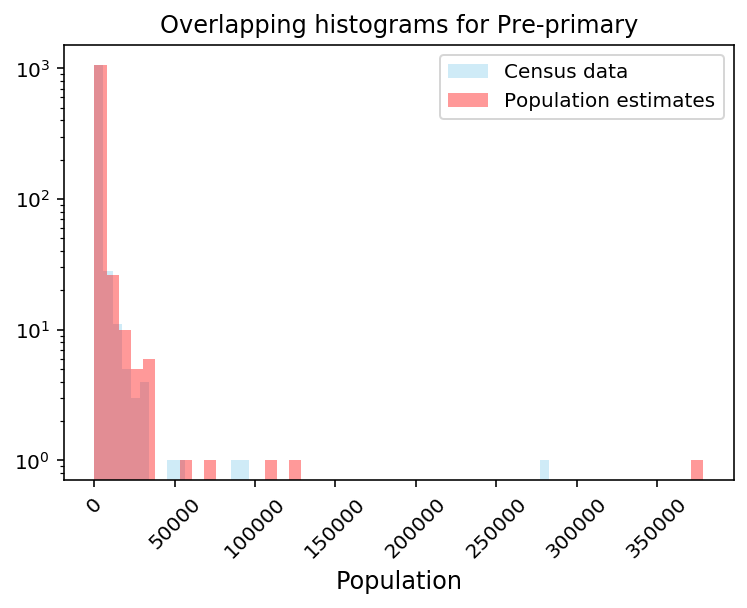

Primary


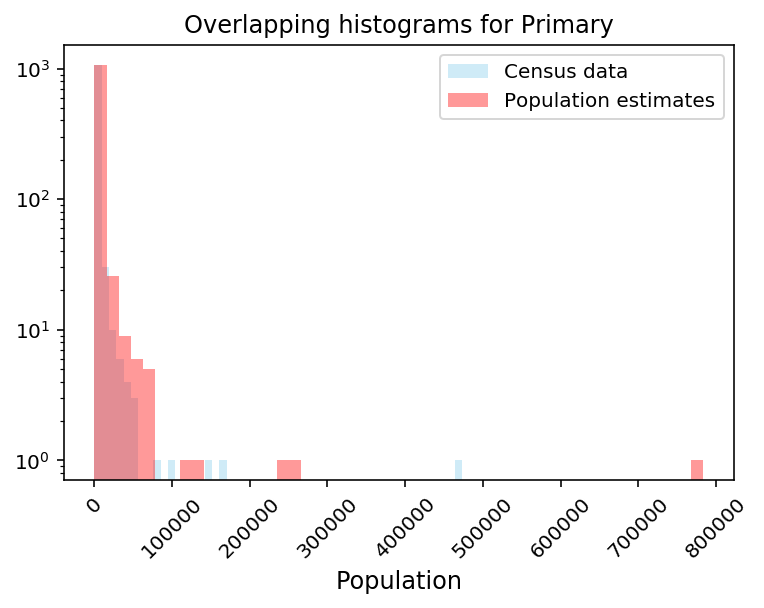

Lower secondary


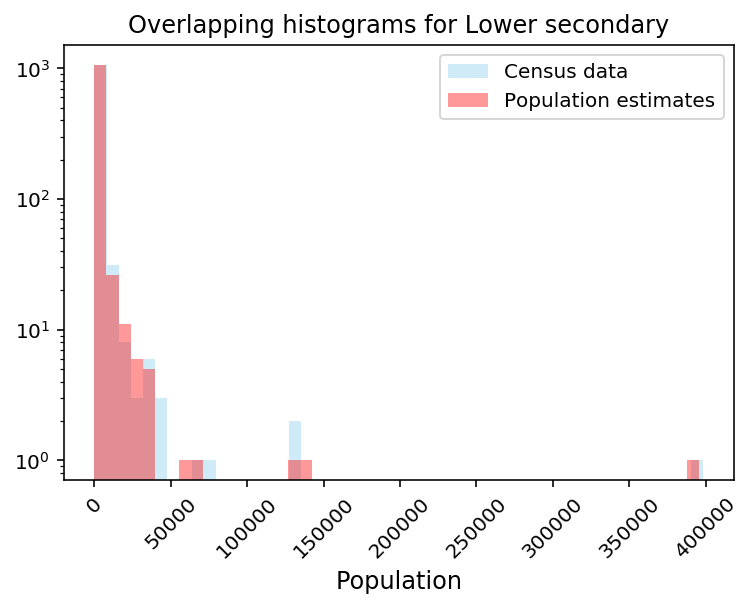

Upper secondary


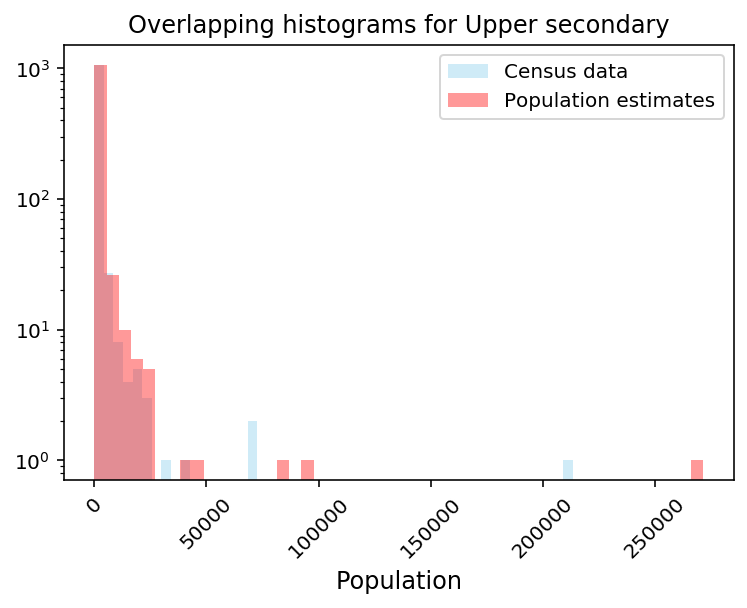

In [18]:
bars = ['Pre-primary', 'Primary', 'Lower secondary', 'Upper secondary']
for x in range(len(Levels)):
    print(bars[x])
    sns.distplot( MergedData["CD_"+Levels[x]] , color="skyblue", label="Census data", hist=True, kde=False, rug=False)
    sns.distplot( MergedData["PE_"+Levels[x]] , color="red", label="Population estimates", hist=True, kde=False, rug=False)
    plt.xlabel('Population', color = 'black', fontsize='12')
    plt.title("Overlapping histograms for " + bars[x])
    plt.legend()
    plt.xticks(color='black', rotation=45)
    plt.yscale('log')
    plt.show()


We then plot to see if the difference between the estimates and the actual data is related to the area of the polygon. While we see that there seems to be some relation, it is also clear that this behavior is also related to densely populated areas. This will be tested further down.

Pre-primary


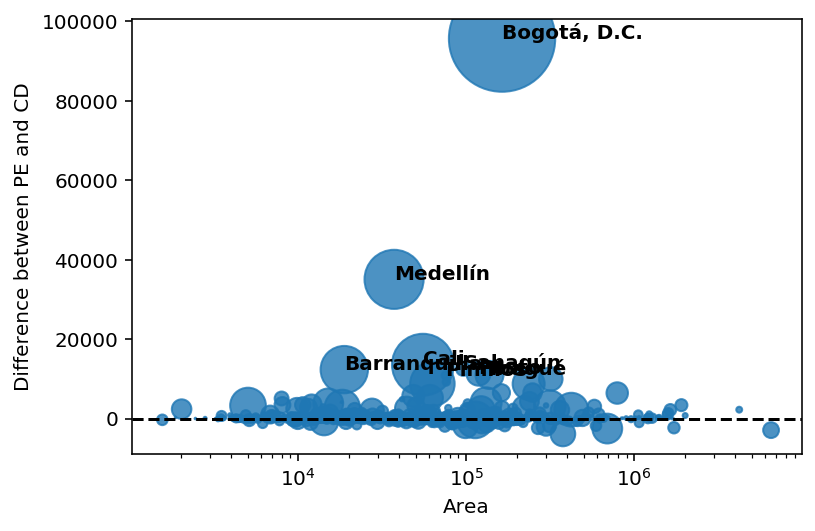

Primary


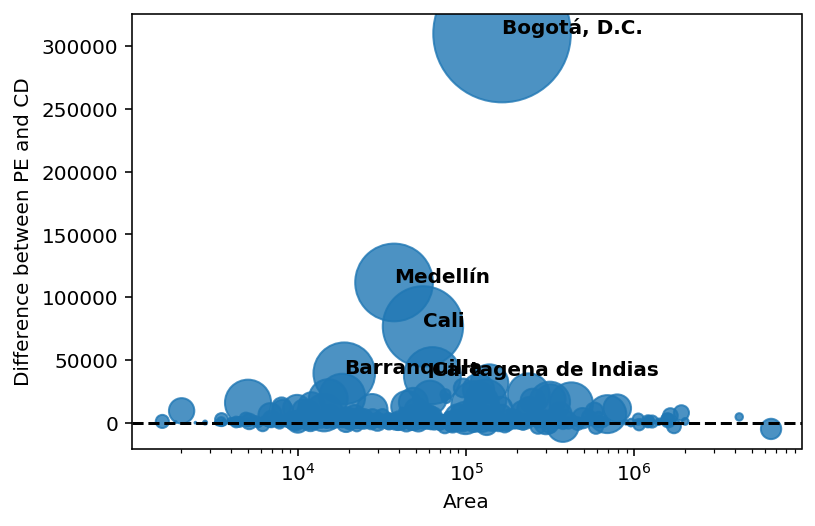

Lower secondary


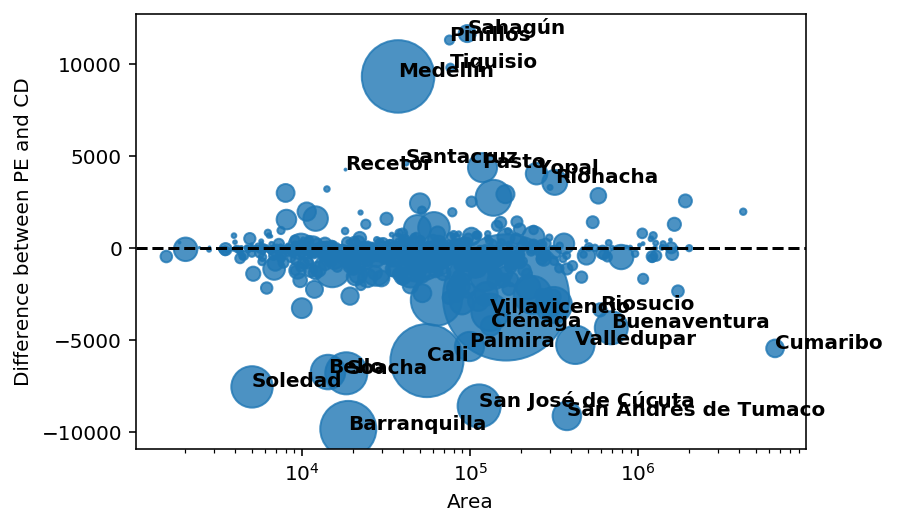

Upper secondary


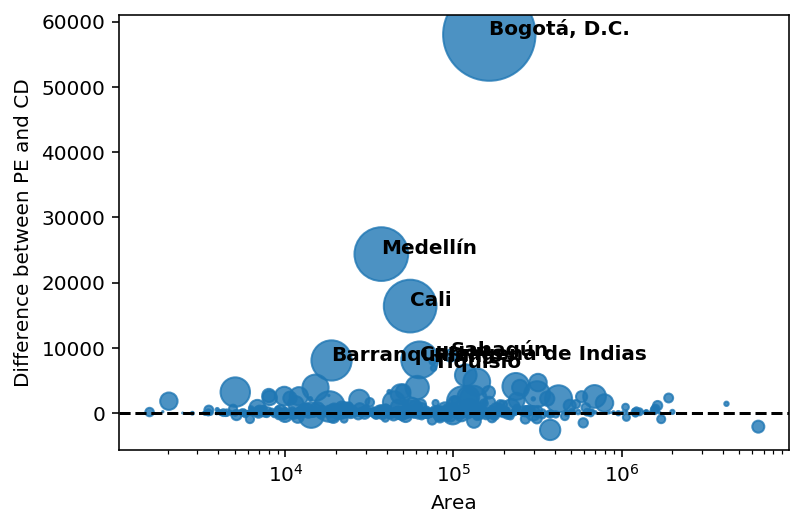

In [19]:
for x in range(len(Levels)):
    MergedData['Label_'+Levels[x]] = np.where(MergedData['Dif_'+Levels[x]]>=MergedData['Dif_'+Levels[x]].mean()+3*MergedData['Dif_'+Levels[x]].std(), MergedData['MunName'],
                                              np.where(MergedData['Dif_'+Levels[x]]<=-MergedData['Dif_'+Levels[x]].mean()-3*MergedData['Dif_'+Levels[x]].std(), MergedData['MunName'], ''))
    print(bars[x])
    p1 = sns.regplot(x=MergedData['Area'], y=MergedData['Dif_'+Levels[x]], scatter_kws={'s':MergedData['CD_'+Levels[x]]/100}, fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['Area'][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

If this methodology is to predict accurately the same information obtained from the Census, a regression fit between both series should yield a regression coefficient close to one.

In [20]:
Results = {}
for x in range(len(Levels)):
    formula = "PE_"+Levels[x]+"_std ~ CD_"+Levels[x]+"_std"
    result = sm.ols(formula=formula, data=MergedData).fit()
    heteroscedasticity_test = diag.het_breuschpagan(result.resid, result.model.exog)
    if heteroscedasticity_test[-1] <= 0.05:
        # The hypothesis that the error variance does not depend on x is rejected. There exists heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit(cov_type='HC0')
        print("Robust regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'Yes'}
    else:
        # The hypothesis that the error variance does not depend on x is kept. There is no heteroscedasticity 
        result = sm.ols(formula=formula, data=MergedData).fit()
        print("Regression results for "+bars[x]+"\n")
        print(result.summary())
        print("\n")
        T_test = result.t_test('CD_'+Levels[x]+'_std = 1')
        print("\nP-Value:{0} T-Statistic:{1}".format(T_test.pvalue,T_test.tvalue[0][0]))
        if T_test.pvalue>0.05:
            print("No statistical difference between census data and population estimates for "+bars[x]+"\n")
        else:
            print("Evidence of statistical difference between census data and population estimates for "+Levels[x]+"\n")
        Results[Levels[x]] = {'Coefficient': T_test.effect[0], 'Std': T_test.sd[0][0], 't_test': T_test.tvalue[0][0], 'p_value': T_test.pvalue, 'R_square':result.rsquared, 'Robust':'No'}


c:\users\g.vargas\documents\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\g.vargas\documents\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Regression results for Pre-primary

                            OLS Regression Results                            
Dep. Variable:      PE_PrePrimary_std   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.052e+05
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:29:54   Log-Likelihood:                 960.55
No. Observations:                1116   AIC:                            -1917.
Df Residuals:                    1114   BIC:                            -1907.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
In

In [21]:
Results = pd.DataFrame.from_dict(Results)
Results = Results.transpose()
Results['ConfidenceInterval'] = 1.98*Results['Std']
Results['Color'] = np.where(Results['Robust']=='Yes','lightblue','darkolivegreen')
Results = Results.transpose()
Results

,PrePrimary,Primary,LowSec,UpSec
Coefficient,0.994747,0.995317,0.996525,0.997309
Std,0.00306699,0.0213089,0.0110444,0.00822827
t_test,-1.71281,-0.219749,-0.314616,-0.327055
p_value,0.08702509839383098,0.8260669453375358,0.7530536022093757,0.7436262233070806
R_square,0.989521,0.990657,0.993063,0.994625
Robust,No,Yes,Yes,Yes
ConfidenceInterval,0.00607264,0.0421917,0.0218679,0.016292
Color,darkolivegreen,lightblue,lightblue,lightblue


We find that these coefficients are statistically equal to 1, with 99% of confidence.

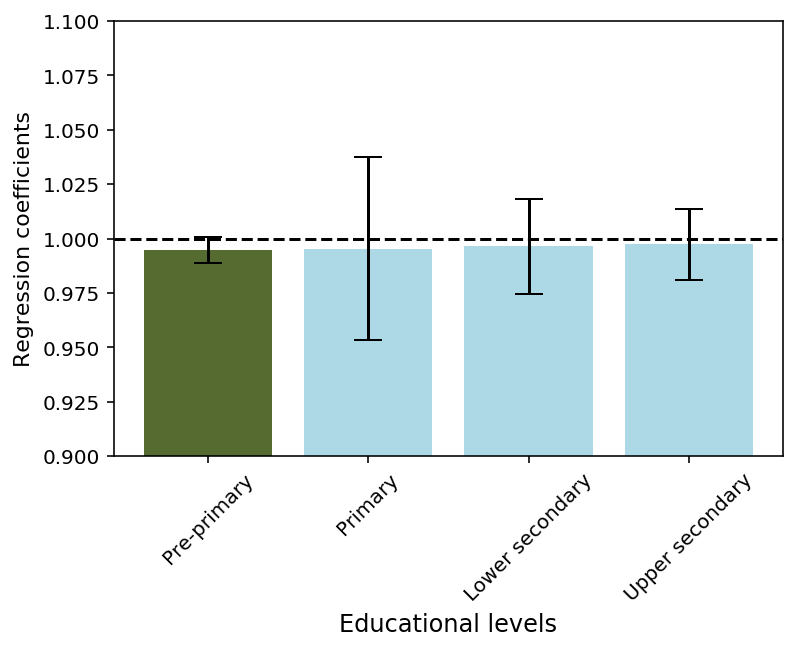

In [22]:
height = list(Results.loc['Coefficient'])
coalors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
yer1 = list(Results.loc['ConfidenceInterval'])
plt.bar(y_pos, height, yerr=yer1, capsize=7, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('Regression coefficients', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.9,1.1)
plt.show()

Furthermore, as is to be expected of such a methodology, the regression fit, the R squared, is very close to 1, which indicated potential multicollineality (a positive trait in this case).

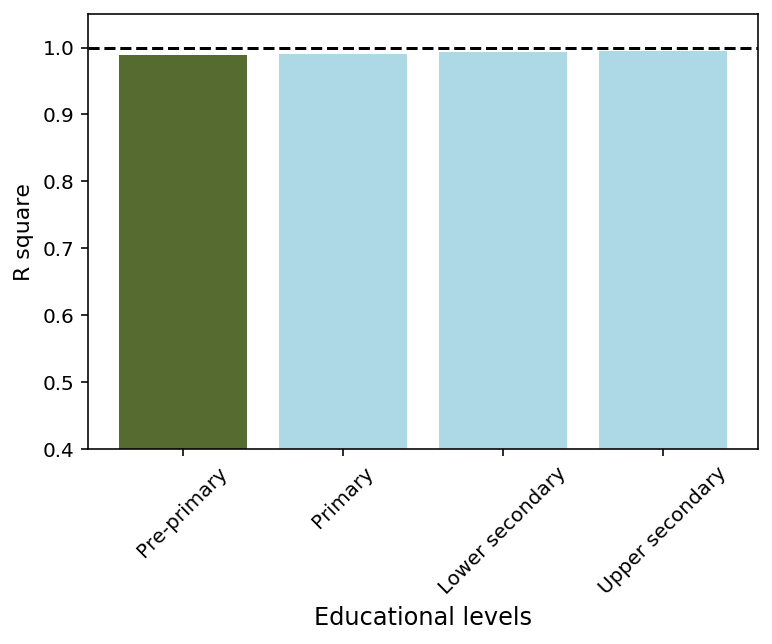

In [23]:
height = list(Results.loc['R_square'])
colors = list(Results.loc['Color'])
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=colors)
plt.xlabel('Educational levels', color = 'black', fontsize='12')
plt.ylabel('R square', color='black', fontsize='11')
plt.xticks(y_pos, bars, color='black', rotation=45)
plt.yticks(color='black')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.ylim(0.4,1.05)
plt.show()

Testing for normality of the difference between both series shows there is not normality, although this is mainly because of considerable outliers (those highly populated areas seen before).

In [ ]:
for x in range(len(Levels)):
    sns.distplot( MergedData["Dif_"+Levels[x]+"_std"])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData["Dif_"+Levels[x]+"_std"])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Most of these outliers are eliminated once this is taken into account (by normalizing the difference between both series by the actual number of inhabitants).

In [ ]:
for x in range(len(Levels)):
    MergedData['Perc_Dif_'+Levels[x]] = MergedData['Dif_'+Levels[x]]/MergedData['CD_'+Levels[x]]*100
    sns.distplot( MergedData['Perc_Dif_'+Levels[x]])
    plt.xlabel(bars[x])
    plt.show()
    jbt = jarque_bera(MergedData['Perc_Dif_'+Levels[x]])
    if jbt[1]>0.05:
        print("The difference between the Population estimates and the")
        print("Census data is normally distributed for "+bars[x])
    else:
        print("The difference between the Population estimates and the")
        print("Census data is not normally distributed for "+bars[x])

Finally, we see there is a high level of heteroscedasticity (as a function of the population size), with variance increasing with the number of people per administrative unit in the census...

Pre-primary


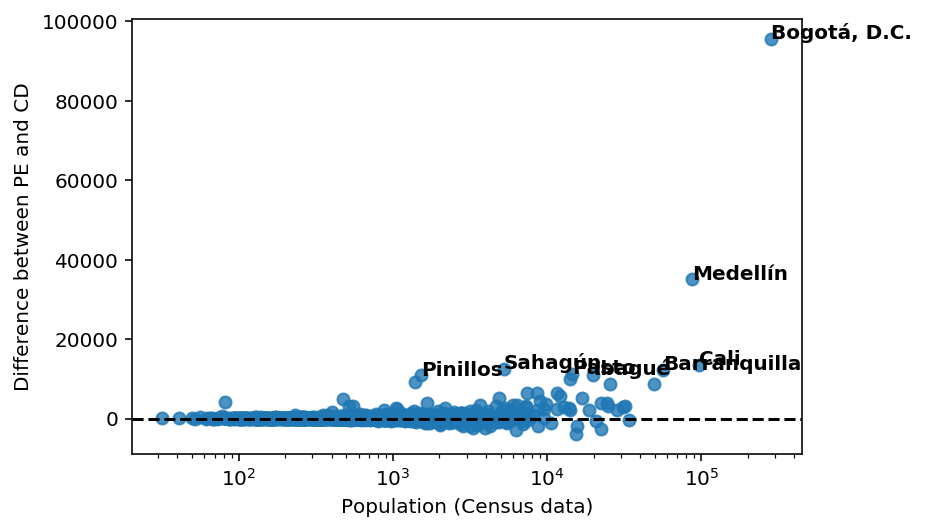

Primary


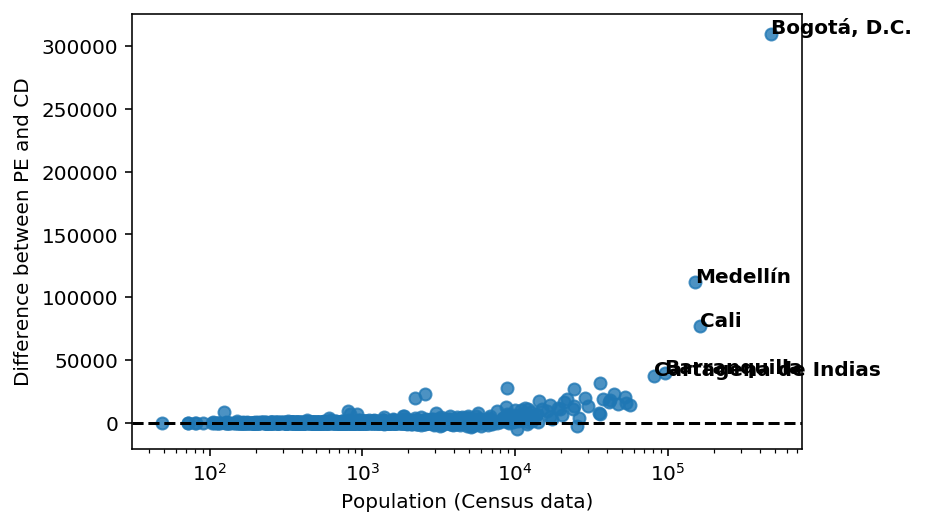

Lower secondary


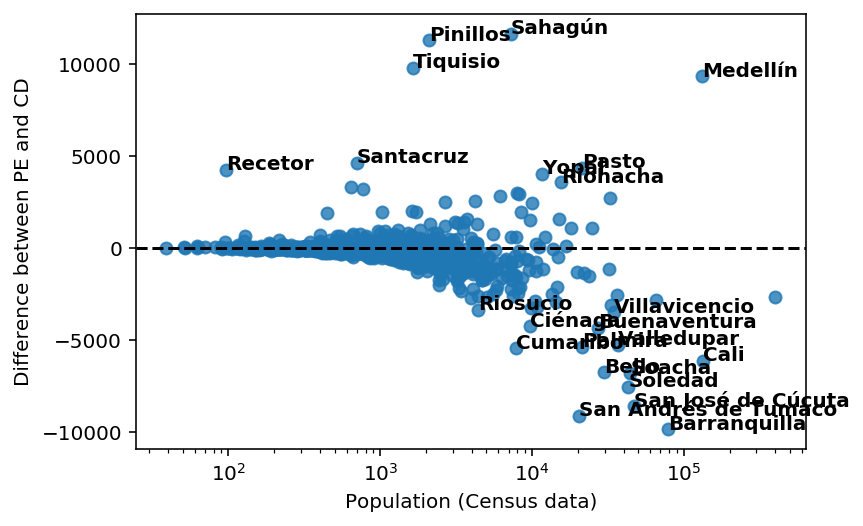

Upper secondary


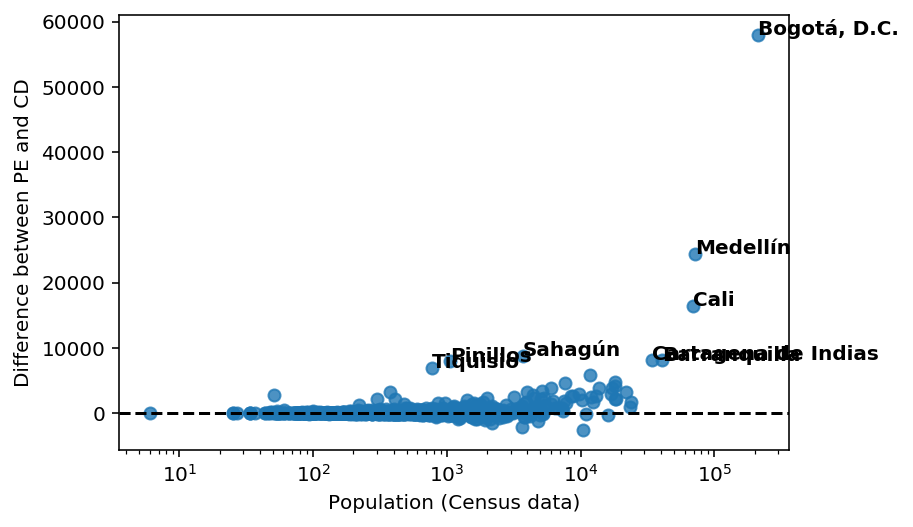

In [25]:
for x in range(len(Levels)):
    print(bars[x])
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Dif_'+Levels[x]], fit_reg=False)
    
    for line in range(0,MergedData.shape[0]):
        p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()

... but such a behavior disappears once we use the percentage of the difference as a function of the total population, rather than the population as a whole.

Pre-primary


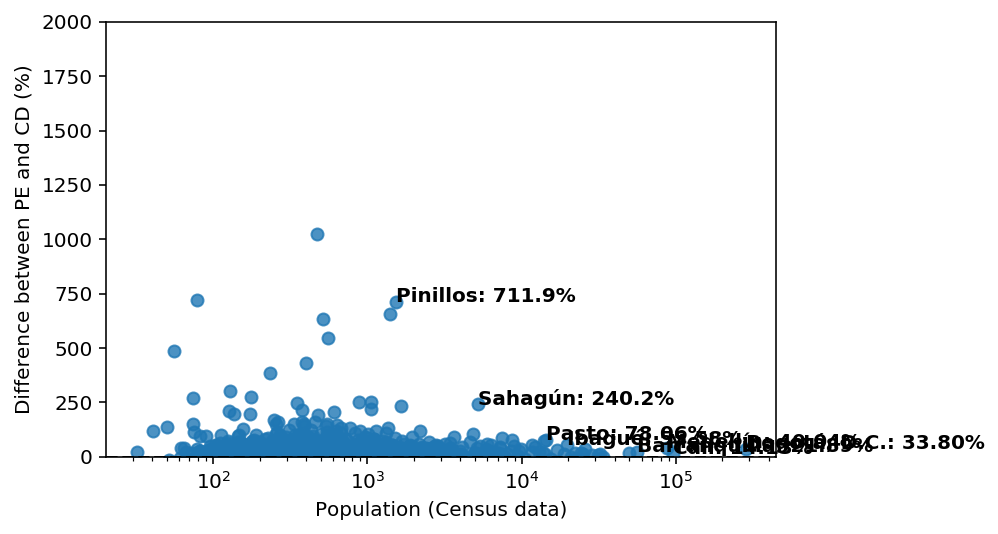

Primary


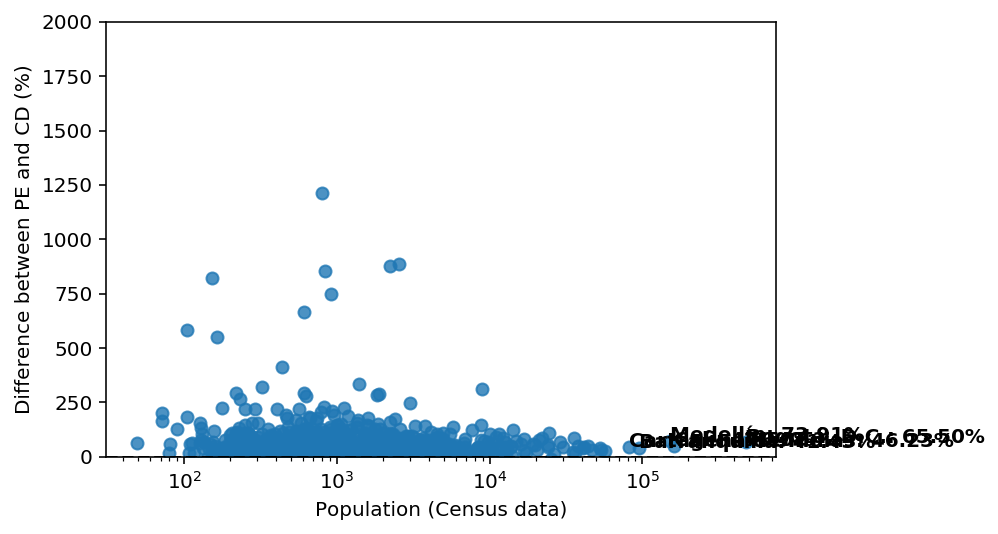

Lower secondary


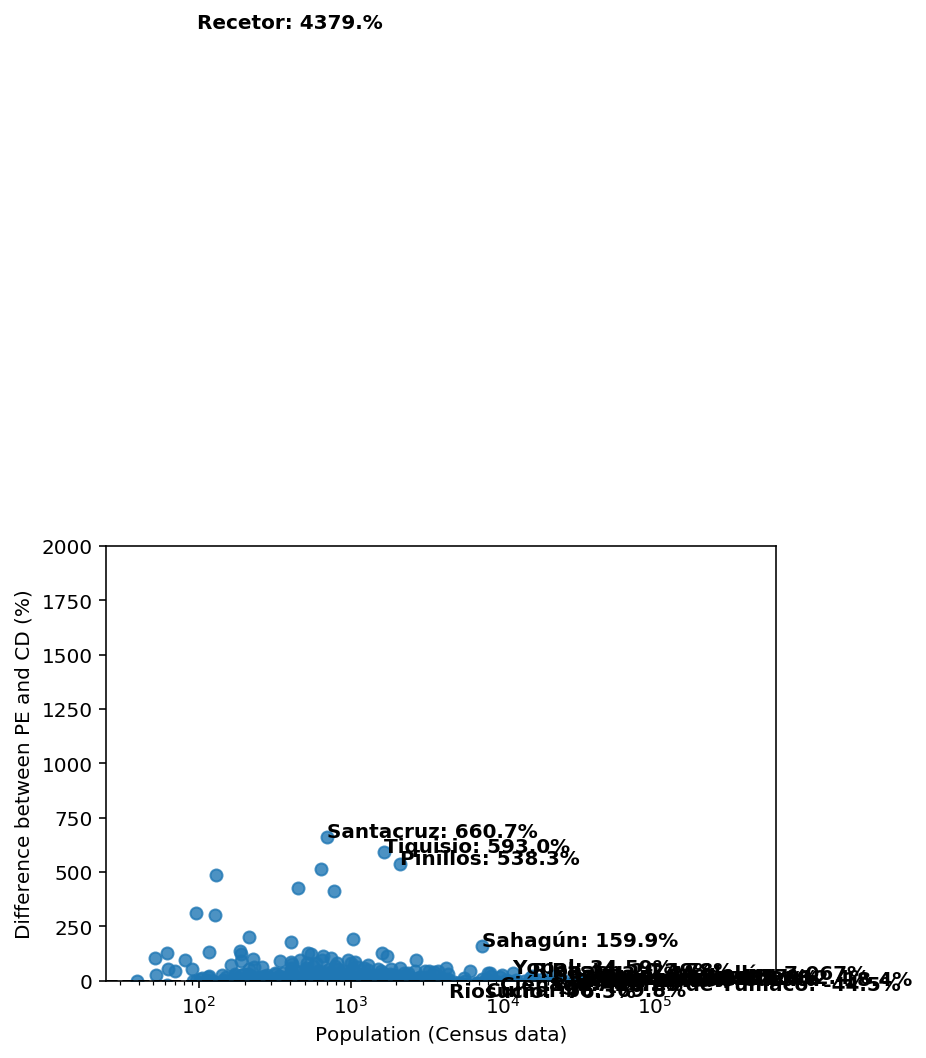

Upper secondary


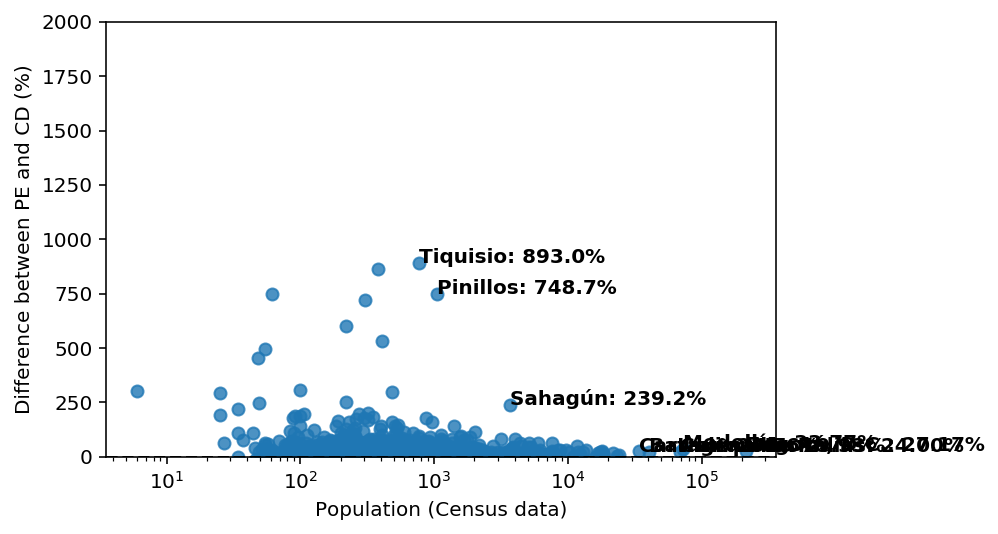

In [27]:
for x in range(len(Levels)):
    print(bars[x])
    MergedData['Perc_Dif_'+Levels[x]] = MergedData['Dif_'+Levels[x]]/MergedData['CD_'+Levels[x]]*100
    p1 = sns.regplot(x=MergedData['CD_'+Levels[x]], y=MergedData['Perc_Dif_'+Levels[x]], fit_reg=False)
    for line in range(0,MergedData.shape[0]):
        if MergedData['Label_'+Levels[x]][line]!='':
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line]+': '+str(MergedData['Perc_Dif_'+Levels[x]][line])[:5]+'%', horizontalalignment='left', size='medium', color='black', weight='semibold')
        else:
            p1.text(MergedData['CD_'+Levels[x]][line]+0.2, MergedData['Perc_Dif_'+Levels[x]][line], MergedData['Label_'+Levels[x]][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylabel('Difference between PE and CD (%)')
    plt.xlabel('Population (Census data)')
    plt.xscale('log')
    plt.ylim(0,2000)
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.show()